In [1]:
import numpy as np
import healpy as hp
import h5py
import matplotlib.pyplot as plt
import matplotlib
from sobol_seq import i4_sobol
from scipy.stats import skew, kurtosis
from tqdm import tqdm

from msfm.utils import files, parameters, input_output
from msfm.grid_pipeline import GridPipeline
from msfm.utils.cosmogrid import get_cosmo_params_info

n_side = 512
n_pix = hp.nside2npix(n_side)

23-09-19 23:50:35   imports.py INF   Setting up healpy to run on 256 CPUs 
23-09-19 23:50:42   imports.py INF   Setting up healpy to run on 256 CPUs 


### CosmoGrid params

In [2]:
cosmo_params_info = get_cosmo_params_info("../../data/CosmoGridV1_metainfo.h5")
print(cosmo_params_info.dtype)

all_Om = cosmo_params_info["Om"]
all_s8 = cosmo_params_info["s8"]
all_w0 = cosmo_params_info["w0"]
all_sobol = cosmo_params_info["sobol_index"]

[('As', '<f8'), ('bary_Mc', '<f8'), ('bary_nu', '<f8'), ('H0', '<f8'), ('O_cdm', '<f8'), ('O_nu', '<f8'), ('Ob', '<f8'), ('Ol', '<f8'), ('Om', '<f8'), ('m_nu', '<f8'), ('ns', '<f8'), ('s8', '<f8'), ('w0', '<f8'), ('wa', '<f8'), ('delta', 'S128'), ('sobol_index', '<i4'), ('benchmark_type', 'S128'), ('id_param', '<i4'), ('path_par', 'S128'), ('box_size_Mpc_over_h', '<f8'), ('n_particles', '<i8'), ('n_shells', '<i4'), ('n_steps', '<i4')]


### Extended params

In [3]:
conf = files.load_config()
sobol_priors = parameters.get_prior_intervals(
    conf["analysis"]["params"]["sobol"] + conf["analysis"]["params"]["ia"] + conf["analysis"]["params"]["bg"]
)

all_bg = []
all_n_bg = []
for i_sobol in all_sobol:
    sobol_point, _ = i4_sobol(sobol_priors.shape[0], i_sobol)
    sobol_params = sobol_point * np.squeeze(np.diff(sobol_priors)) + sobol_priors[:, 0]
    sobol_params = sobol_params.astype(np.float32)

    Aia = sobol_params[6]
    n_Aia = sobol_params[7]
    bg = sobol_params[8]
    n_bg = sobol_params[9]

    all_bg.append(bg)
    all_n_bg.append(n_bg)

# $\sigma_8 - b_g$ degeneracy

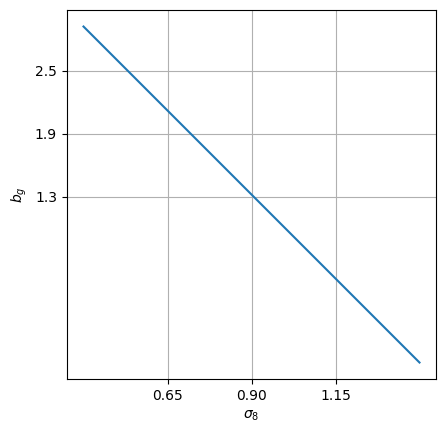

In [4]:
# b_g = -3.2 sigma_8 + 4.2
s8_prior = np.squeeze(parameters.get_prior_intervals(["s8"]))
x = np.linspace(s8_prior[0], s8_prior[1], 50)


fig, ax = plt.subplots()
ax.plot(x, -3.2*x + 4.2)
ax.set_xticks([0.65, 0.9, 1.15])
ax.set_yticks([1.3, 1.9, 2.5])
ax.set_box_aspect(1)
ax.set(xlabel=r"$\sigma_8$", ylabel=r"$b_g$")
ax.grid(True)

In [5]:
assert len(all_Om) == len(all_s8) == len(all_w0) == len(all_bg) == len(all_n_bg)

# degenerate cosmos in the sigma_8, b_g plane
deg_sobol = []
for i, (sobol, Om, s8, w0, bg, n_bg) in enumerate(zip(all_sobol, all_Om, all_s8, all_w0, all_bg, all_n_bg)):
    
    # sigma_8 - b_g degeneracy plane 
    if np.abs(-3.2 * s8 + 4.2 - bg) <= 0.2:

        # Omega_m, w0 and n_bg
        if np.abs(Om - 0.25) <= 0.05 and np.abs(w0 + 1.0) <= 0.3 and np.abs(n_bg - 0.5) <= 0.5:
            deg_sobol.append(sobol)
            
print(len(deg_sobol))
print(deg_sobol)

21
[20, 451, 835, 996, 1500, 3068, 3179, 6124, 23508, 32276, 37571, 70668, 84100, 111364, 122139, 147227, 148451, 177147, 181964, 189395, 198996]


# plots

### loop through all of the grid data

In [6]:
pipeline_kwargs = {
    "with_lensing": False,
    "with_clustering": True,
    "apply_norm": False,
    "with_padding": True,
}
grid_pipe = GridPipeline(**pipeline_kwargs)
data_vec_pix = grid_pipe.data_vec_pix

23-08-30 23:56:32     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 
23-08-30 23:56:32     files.py INF   Loaded the pixel file /global/u2/a/athomsen/multiprobe-simulation-forward-model/data/DESY3_pixels_512.h5 


In [9]:
dset_kwargs = {
    "i_noise" : 0,
    "local_batch_size": "cosmo",
    # bad for performance, but ensures there's only a single cosmology per batch
    "n_readers": 1,
    "n_prefetch": 1,
}
grid_dset = grid_pipe.get_dset(tfr_pattern="/pscratch/sd/a/athomsen/DESY3/v4/extra_large_scales/tfrecords/grid/DESy3_grid_???.tfrecord", **dset_kwargs)
# grid_dset = grid_pipe.get_dset(tfr_pattern="/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v4/large_scales/tfrecords/DESy3_grid_???.tfrecord", **dset_kwargs)

23-08-30 23:57:34 grid_pipelin INF   Interleaving with n_readers = 1 
23-08-30 23:57:34 grid_pipelin INF   The dset is batched by cosmology 
23-08-30 23:57:34 grid_pipelin INF   Batching into 16 elements locally 
23-08-30 23:57:34 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental

In [10]:
# %%time
# data_vectors = []
# cosmos = []
# for data_vector, cosmo, index in tqdm(grid_dset, total=2500):
#     if index[0][0] in deg_sobol:
#         data_vectors.append(data_vector)
#         cosmos.append(cosmo)
        
#         print(f"{len(data_vectors)}/{len(deg_sobol)}: {index[0][0]}")

  0%|          | 11/2500 [00:05<18:03,  2.30it/s]

1/21: 20


  7%|▋         | 185/2500 [01:26<19:12,  2.01it/s]

2/21: 451


 13%|█▎        | 326/2500 [02:33<17:16,  2.10it/s]

3/21: 835


 16%|█▌        | 391/2500 [03:05<17:42,  1.99it/s]

4/21: 996


 24%|██▎       | 588/2500 [05:07<38:40,  1.21s/it]

5/21: 1500


 47%|████▋     | 1180/2500 [11:03<11:15,  1.95it/s] 

6/21: 3068


 49%|████▉     | 1224/2500 [11:26<10:54,  1.95it/s]

7/21: 3179


 51%|█████     | 1281/2500 [11:55<10:50,  1.87it/s]

8/21: 6124


 55%|█████▌    | 1385/2500 [12:46<09:10,  2.03it/s]

9/21: 23508


 57%|█████▋    | 1435/2500 [13:14<13:32,  1.31it/s]

10/21: 32276


 59%|█████▊    | 1466/2500 [13:47<21:49,  1.27s/it]

11/21: 37571


 67%|██████▋   | 1669/2500 [15:47<07:51,  1.76it/s]

12/21: 70668


 70%|██████▉   | 1747/2500 [17:08<06:31,  1.92it/s]

13/21: 84100


 77%|███████▋  | 1931/2500 [20:42<04:19,  2.19it/s]

14/21: 111364


 80%|███████▉  | 1994/2500 [21:12<03:43,  2.26it/s]

15/21: 122139


 86%|████████▌ | 2138/2500 [22:41<03:20,  1.81it/s]

16/21: 147227


 86%|████████▌ | 2147/2500 [22:46<03:11,  1.84it/s]

17/21: 148451


 93%|█████████▎| 2335/2500 [24:26<01:34,  1.75it/s]

18/21: 177147


 95%|█████████▍| 2363/2500 [24:41<01:14,  1.84it/s]

19/21: 181964


 96%|█████████▌| 2405/2500 [25:09<00:54,  1.74it/s]

20/21: 189395


 98%|█████████▊| 2462/2500 [25:47<00:17,  2.13it/s]

21/21: 198996


100%|█████████▉| 2499/2500 [26:05<00:00,  1.60it/s]

CPU times: user 10min 41s, sys: 23min 48s, total: 34min 30s
Wall time: 26min 5s


In [11]:
# with h5py.File("./s8_bg_degeneracy_extra_large_scales.h5", "w") as f:
#     f.create_dataset(name="data_vectors", data=data_vectors)
#     f.create_dataset(name="cosmos", data=cosmos)
#     f.create_dataset(name="sobol", data=deg_sobol)


### load the selected cosmologies

In [2]:
file_label = "large_scales"
# file_label = "extra_large_scales"

In [3]:
with h5py.File(f"./s8_bg_degeneracy_{file_label}.h5", "r") as f:
    data_vectors = f["data_vectors"][:]
    cosmos = f["cosmos"][:]

# shapes
n_cosmos = data_vectors.shape[0]
n_examples = data_vectors.shape[1]
n_tomo = data_vectors.shape[3]
print(data_vectors.shape)

cosmos = cosmos[:,0]
print(cosmos.shape)

# sort by sigma_8
i_sort = np.argsort(cosmos[:,1])
data_vectors = data_vectors[i_sort]
cosmos = cosmos[i_sort]

(21, 16, 464896, 4)
(21, 10)


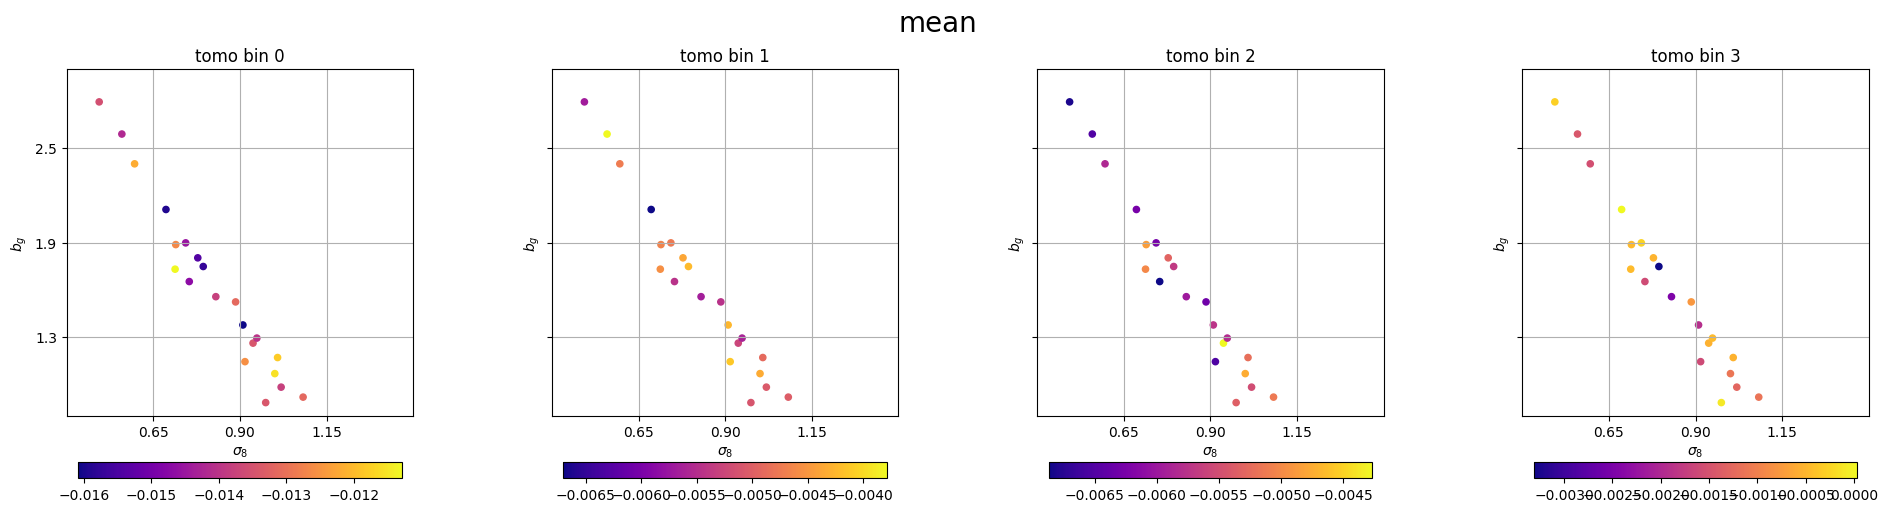

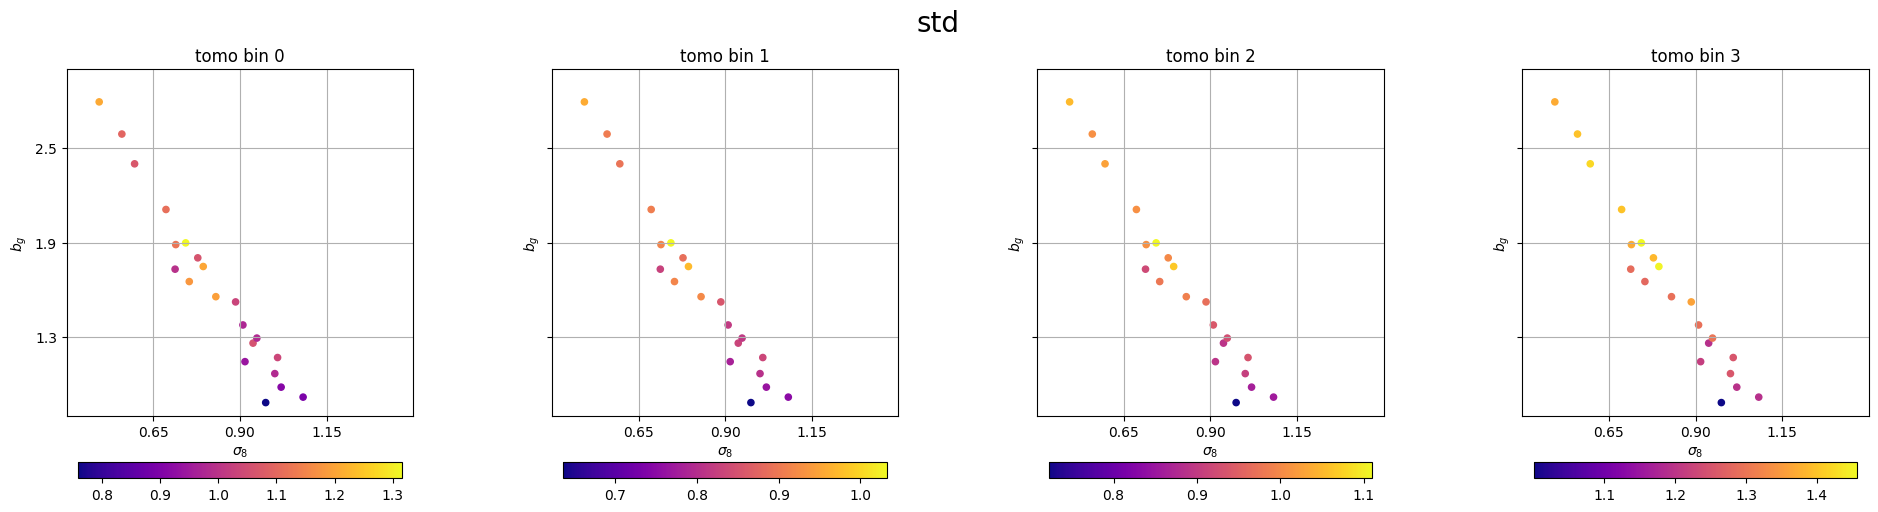

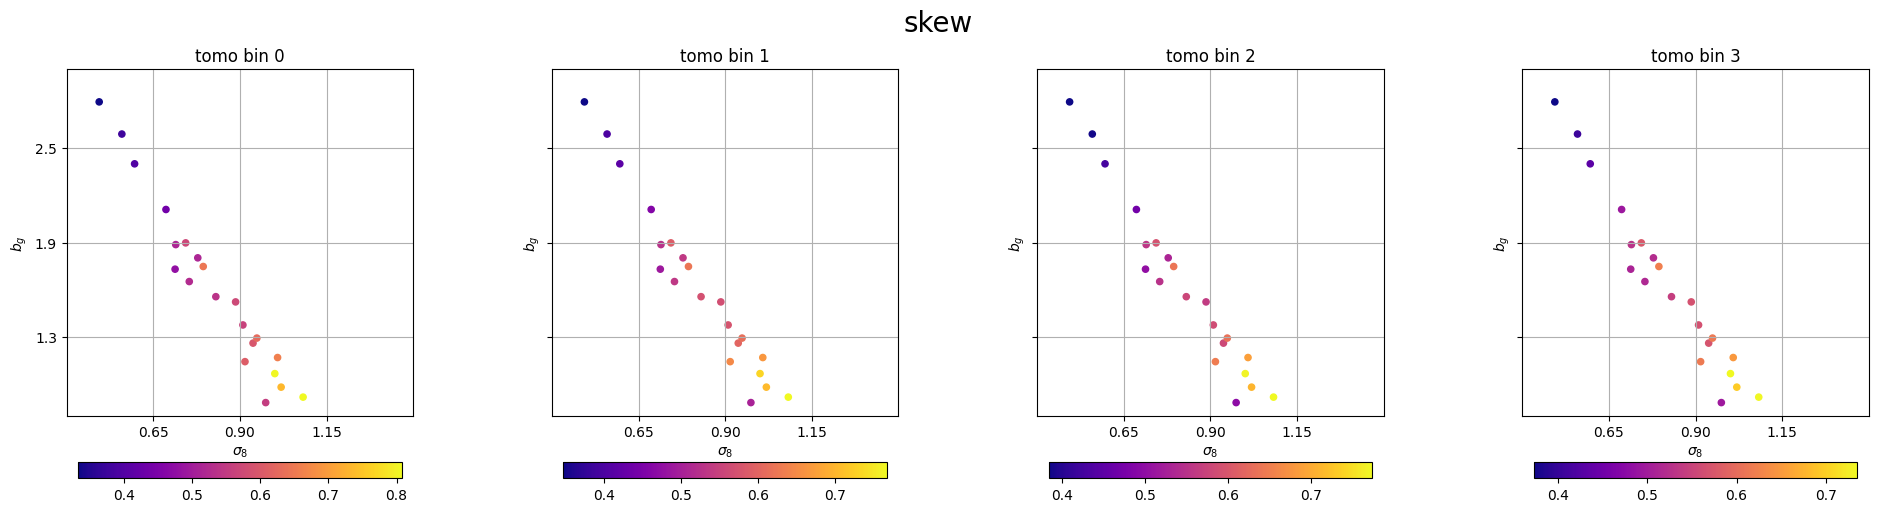

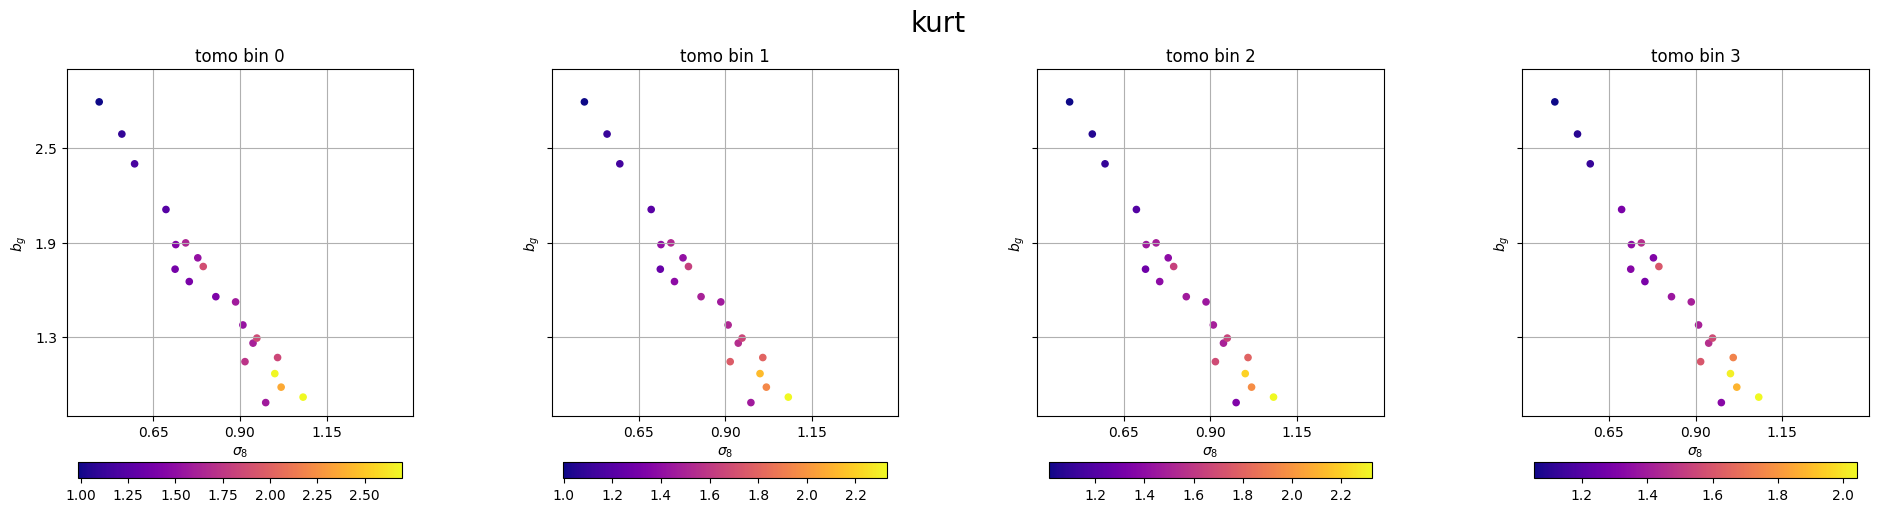

In [8]:
pix_stats = []

# numpy
pix_stats.append(np.mean(data_vectors, axis=(1,2)))
pix_stats.append(np.std(data_vectors, axis=(1,2)))

# scipy
third = np.zeros((n_cosmos, n_tomo))
for i in range(n_cosmos):
    for j in range(n_tomo):
        third[i,j] = skew(data_vectors[i,:,:,j], axis=None)
pix_stats.append(third)

fourth = np.zeros((n_cosmos, n_tomo))
for i in range(n_cosmos):
    for j in range(n_tomo):
        fourth[i,j] = kurtosis(data_vectors[i,:,:,j], axis=None)
pix_stats.append(fourth)

# plot
labels = ["mean", "std", "skew", "kurt"]
s8 = cosmos[:,1]
bg = cosmos[:,8]

for pix_stat, label in zip(pix_stats, labels):
    fig, ax = plt.subplots(nrows=1, ncols=n_tomo, sharex="all", sharey="row", figsize=(6*n_tomo, 6))

    for i in range(n_tomo):
        # s8 - bg plane
        im = ax[i].scatter(s8, bg, c=pix_stat[:,i], cmap="plasma", s=20)
        
        # cosmetics
        ax[i].set_box_aspect(1)
        ax[i].grid(True)
        ax[i].set(title=f"tomo bin {i}", xlim=(0.4, 1.4), ylim=(0.8, 3.0), xlabel=r"$\sigma_8$", ylabel=r"$b_g$")
        ax[i].set_xticks([0.65, 0.9, 1.15])
        ax[i].set_yticks([1.3, 1.9, 2.5])
    
        # colorbar
        fig.colorbar(im, ax=ax[i], orientation="horizontal", shrink=0.8, pad=0.1)

    fig.suptitle(label, fontsize=20)
    fig.savefig(f"plots/reduced_scatter_{label}_{file_label}.png", bbox_inches="tight", dpi=200)

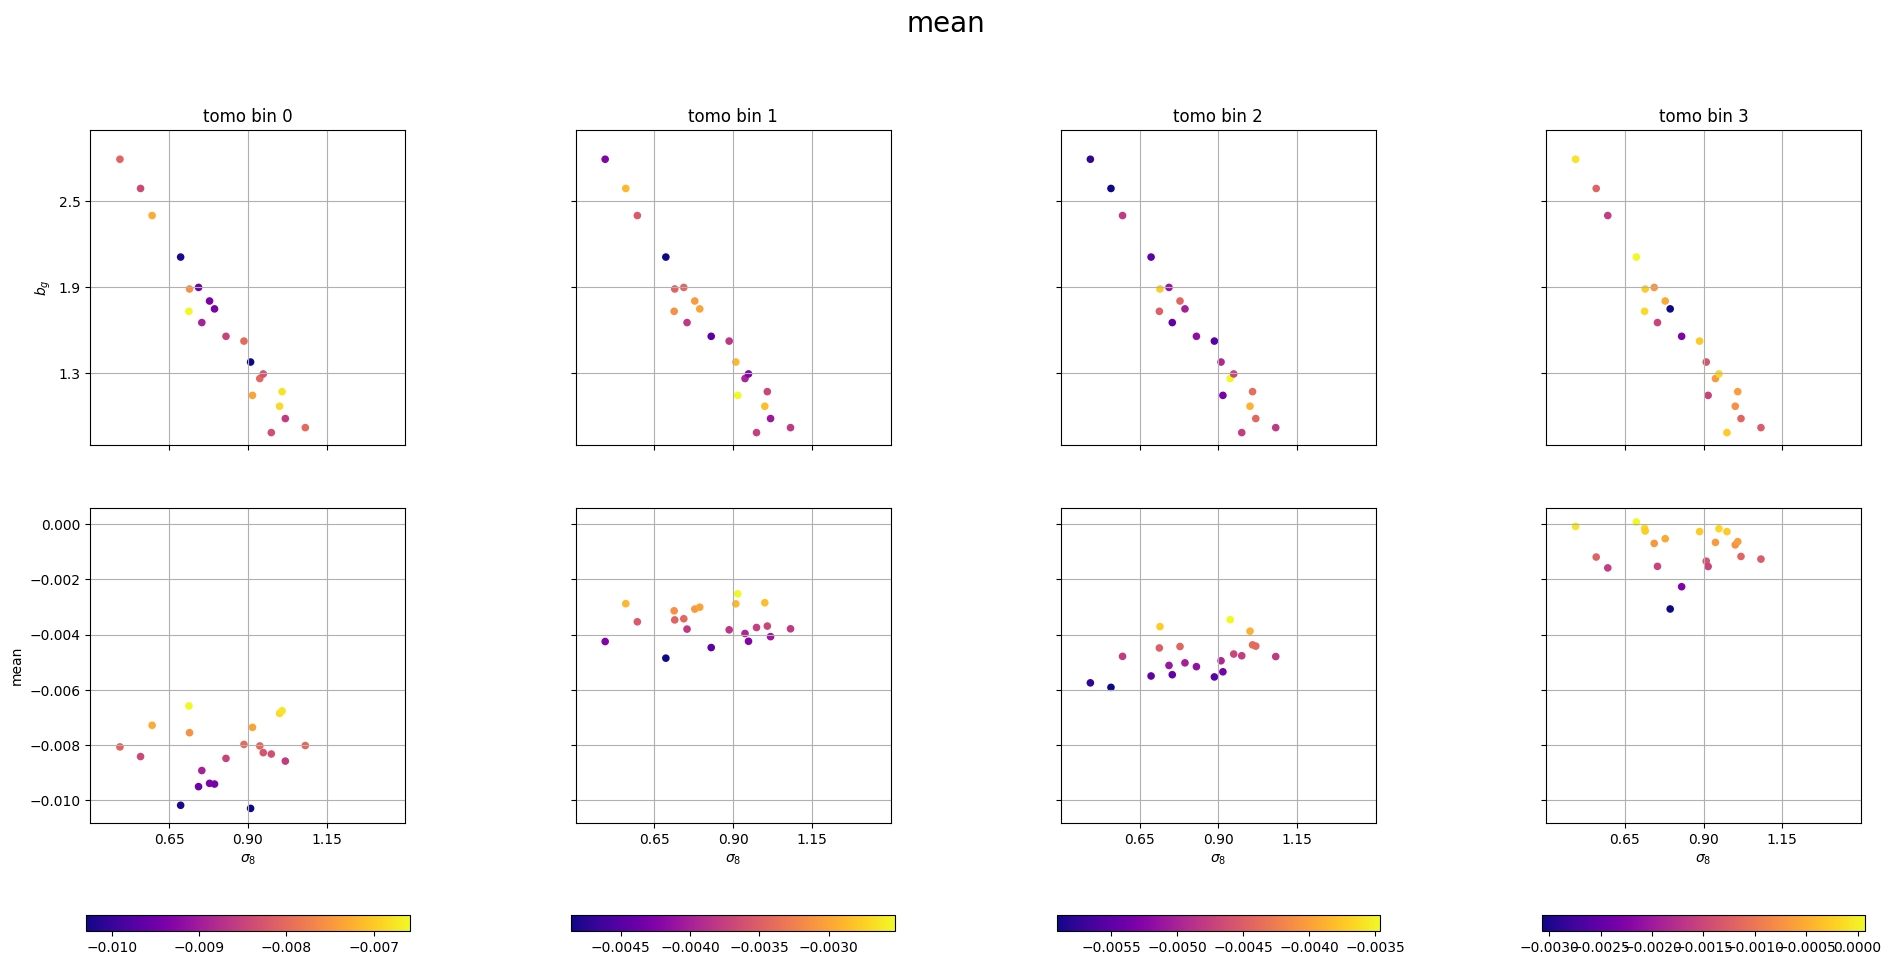

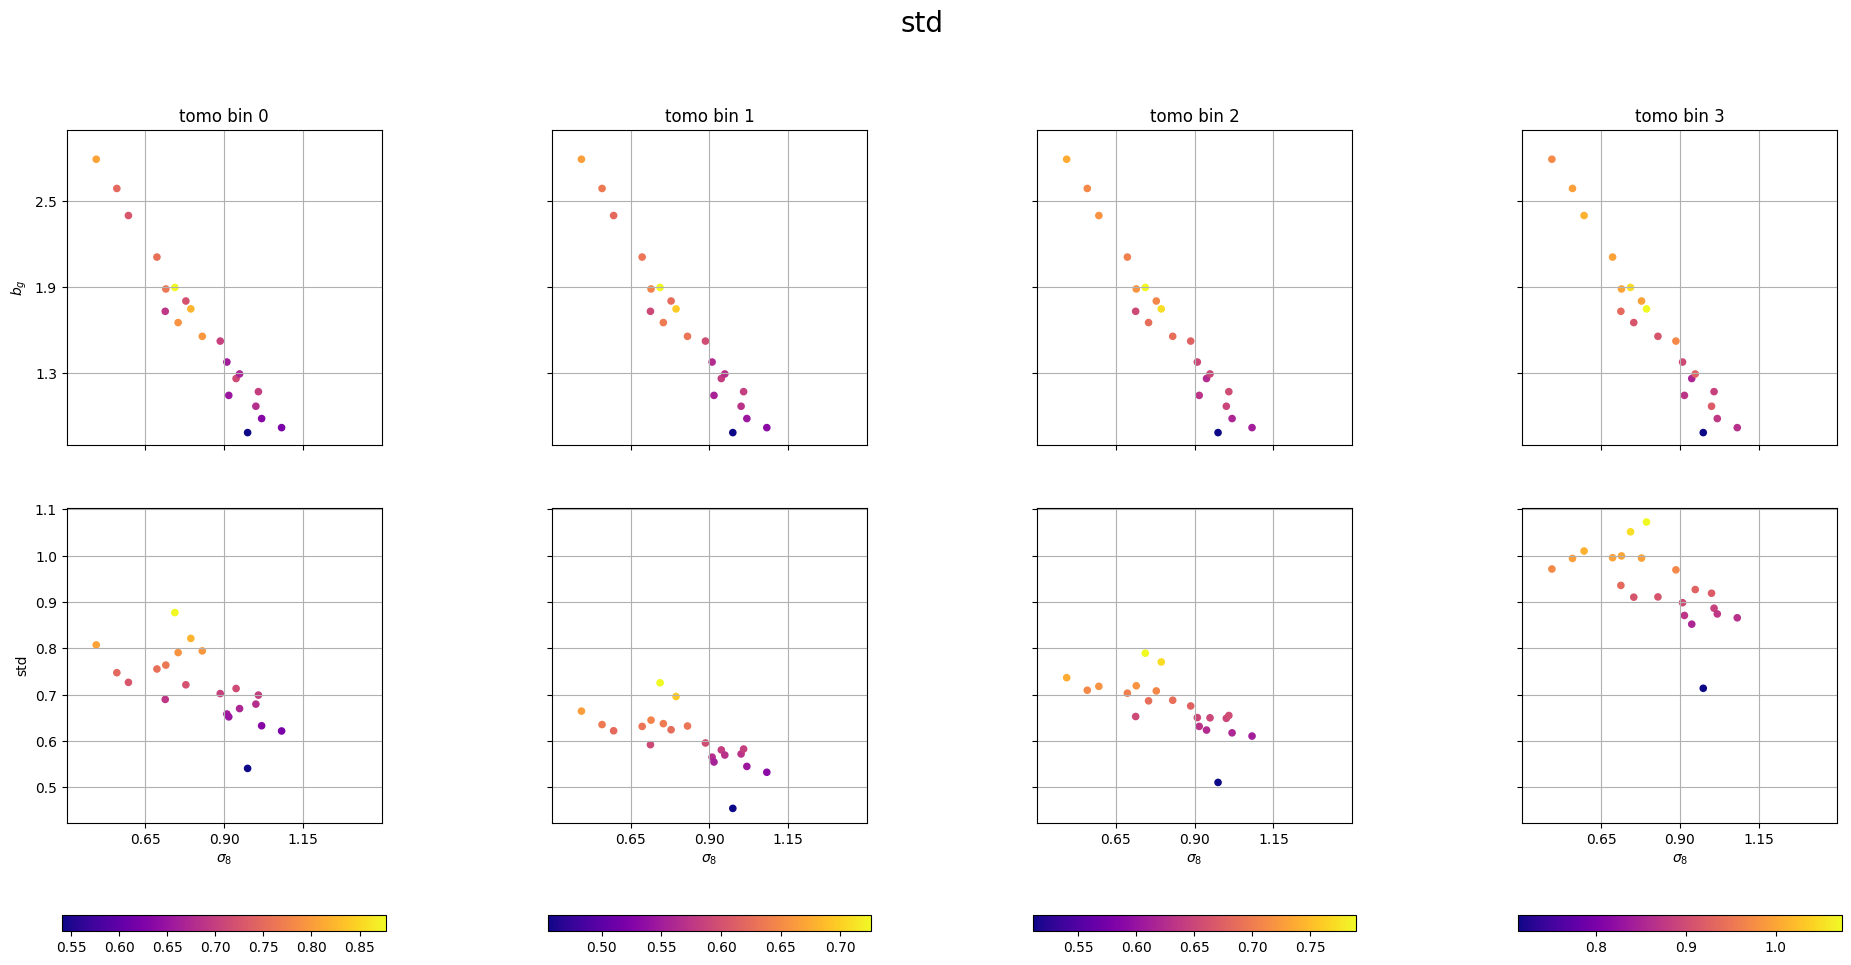

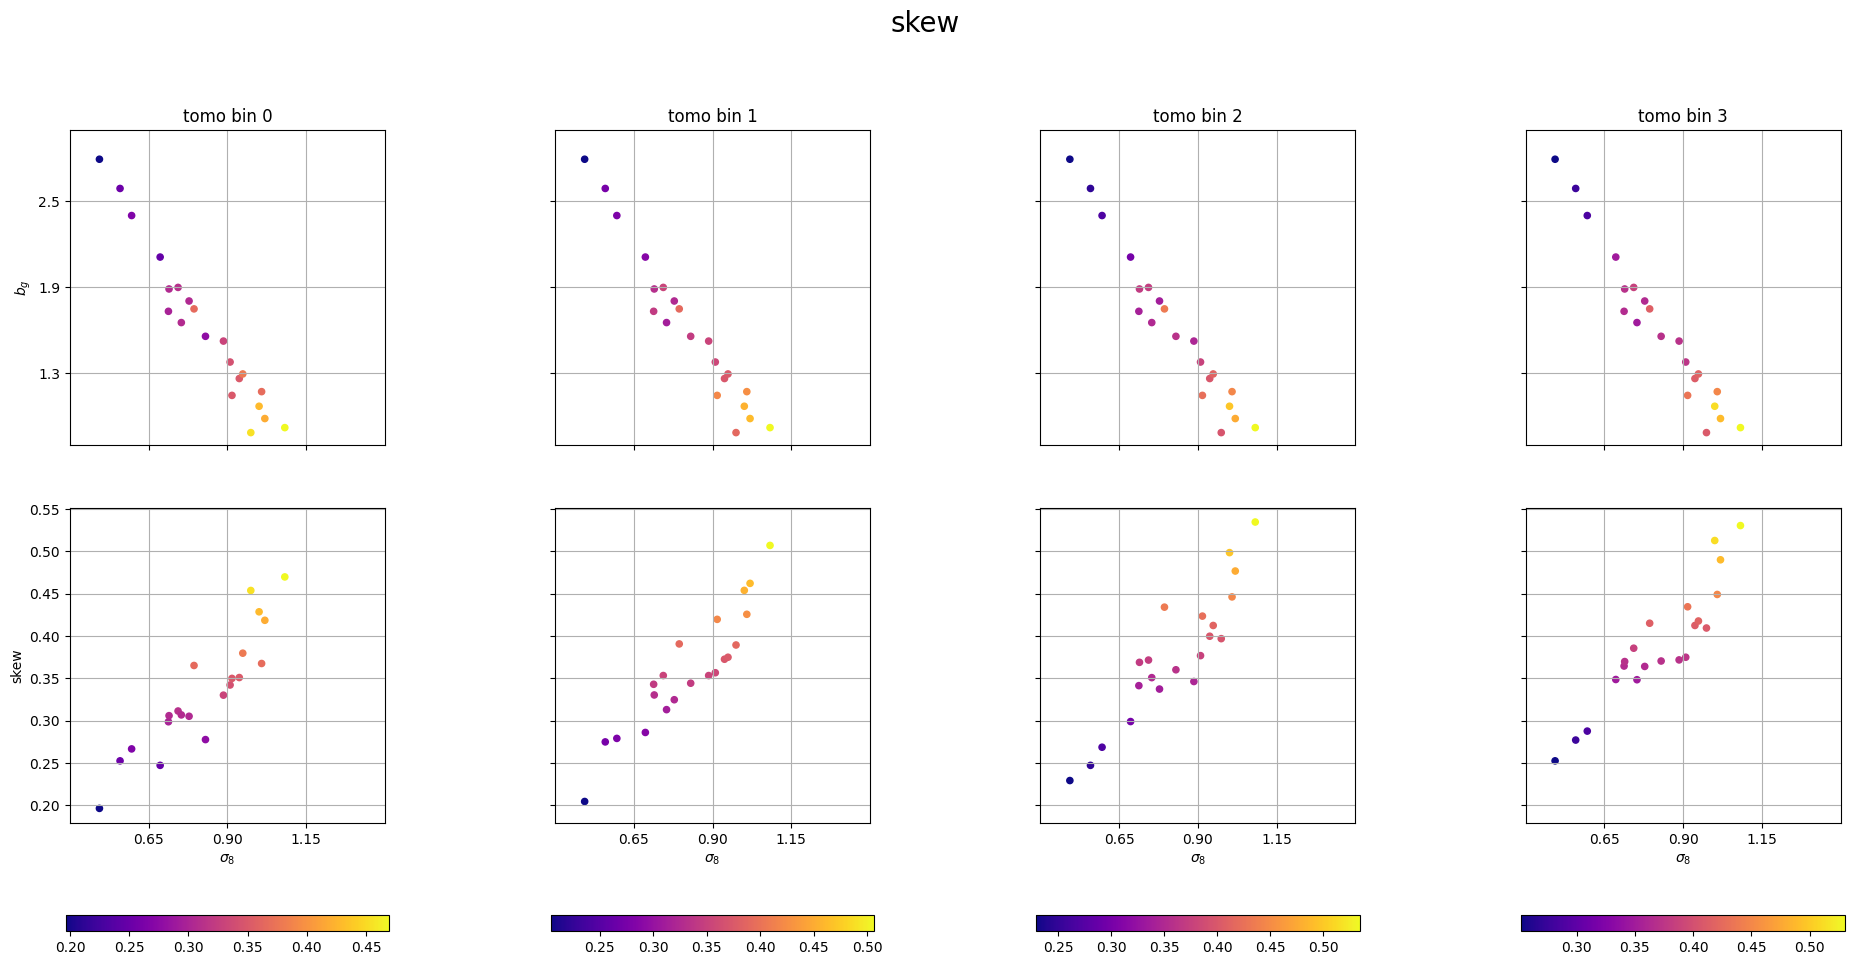

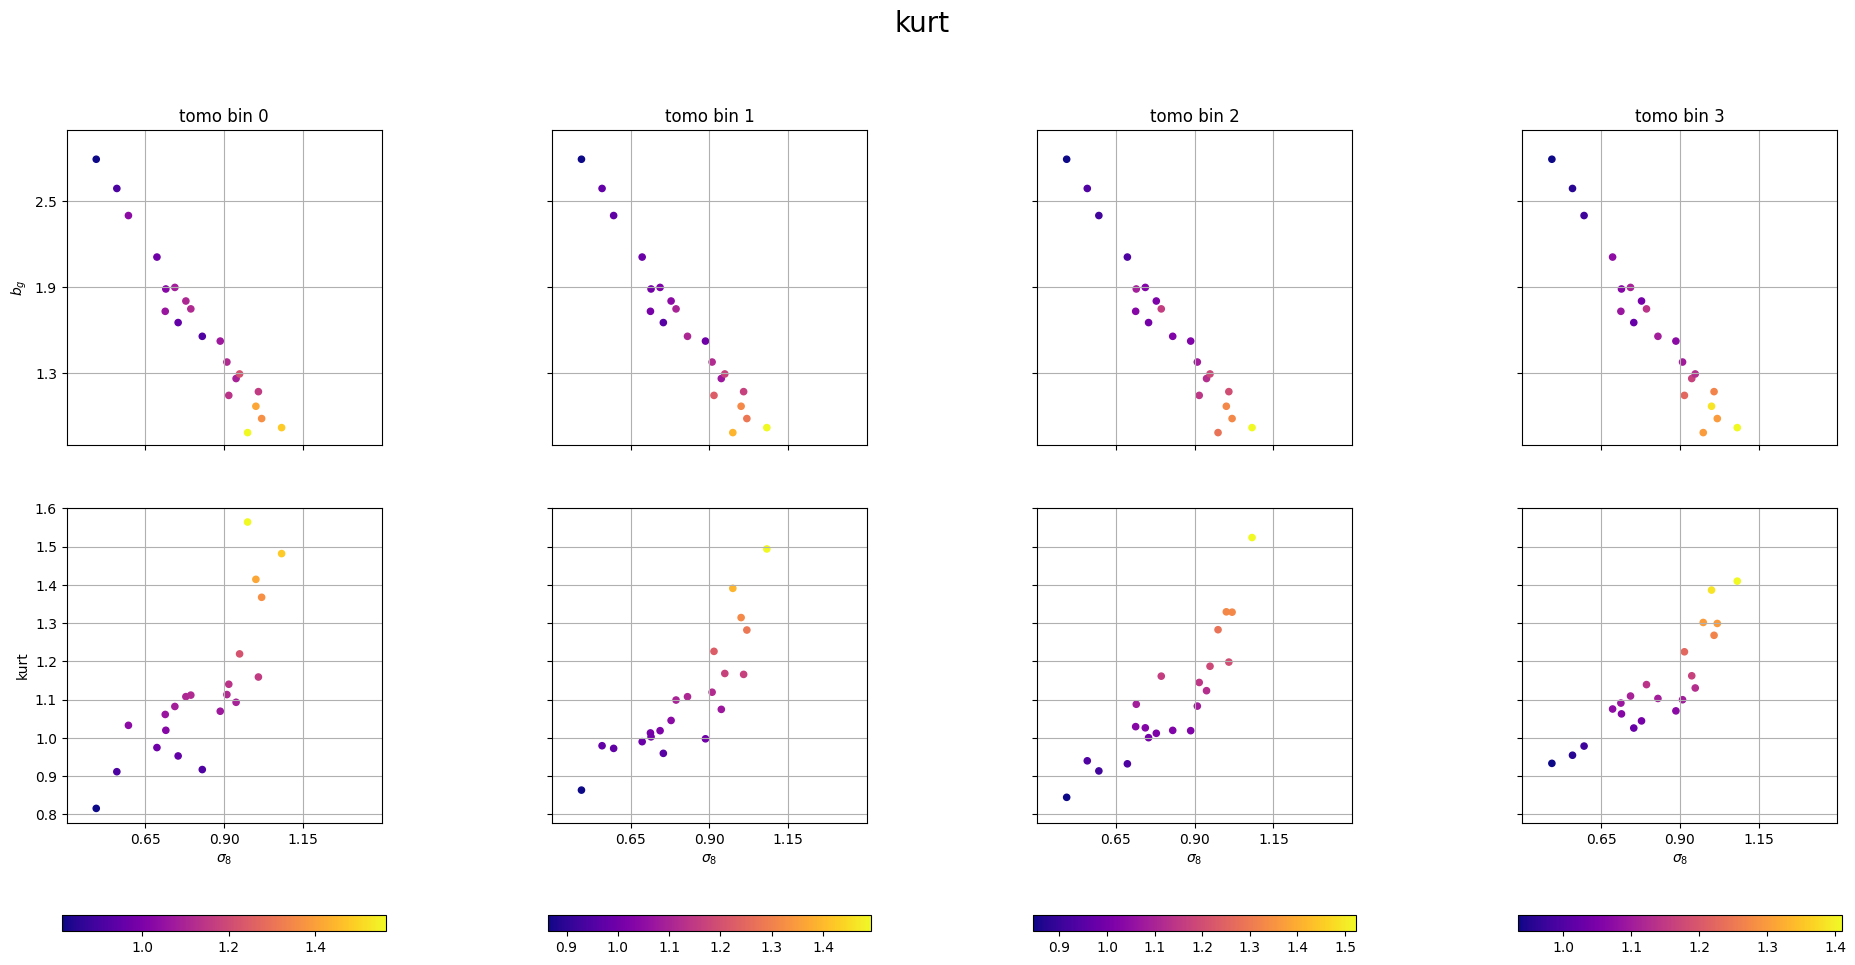

In [26]:
pix_stats = []

# numpy
pix_stats.append(np.mean(data_vectors, axis=(1,2)))
pix_stats.append(np.std(data_vectors, axis=(1,2)))

# scipy
third = np.zeros((n_cosmos, n_tomo))
for i in range(n_cosmos):
    for j in range(n_tomo):
        third[i,j] = skew(data_vectors[i,:,:,j], axis=None)
pix_stats.append(third)

fourth = np.zeros((n_cosmos, n_tomo))
for i in range(n_cosmos):
    for j in range(n_tomo):
        fourth[i,j] = kurtosis(data_vectors[i,:,:,j], axis=None)
pix_stats.append(fourth)

# plot
labels = ["mean", "std", "skew", "kurt"]
s8 = cosmos[:,1]
bg = cosmos[:,8]

for pix_stat, label in zip(pix_stats, labels):
    fig, ax = plt.subplots(nrows=2, ncols=n_tomo, sharex="all", sharey="row", figsize=(6*n_tomo, 6*2))

    for i in range(n_tomo):
        # s8 - bg plane
        im = ax[0,i].scatter(s8, bg, c=pix_stat[:,i], cmap="plasma", s=20)
        
        # cosmetics
        ax[0,i].set_box_aspect(1)
        ax[0,i].grid(True)
        ax[0,i].set(title=f"tomo bin {i}", xlim=(0.4, 1.4), ylim=(0.8, 3.0))
        ax[0,i].set_xticks([0.65, 0.9, 1.15])
        ax[0,i].set_yticks([1.3, 1.9, 2.5])

        # s8 - statistic plane
        im = ax[1,i].scatter(s8, pix_stat[:,i], c=pix_stat[:,i], cmap="plasma", s=20)
        
        # cosmetics
        ax[1,i].set_box_aspect(1)
        ax[1,i].grid(True)
        ax[1,i].set(xlabel=r"$\sigma_8$")

        if i == 0:
            ax[0,i].set(ylabel=r"$b_g$")
            ax[1,i].set(ylabel=label)
    
        # colorbar
        fig.colorbar(im, ax=ax[:,i], orientation="horizontal", shrink=0.8, pad=0.1)

    fig.suptitle(label, fontsize=20)
    fig.savefig(f"plots/scatter_{label}_{file_label}.png", bbox_inches="tight", dpi=200)

100%|██████████| 21/21 [00:34<00:00,  1.62s/it]


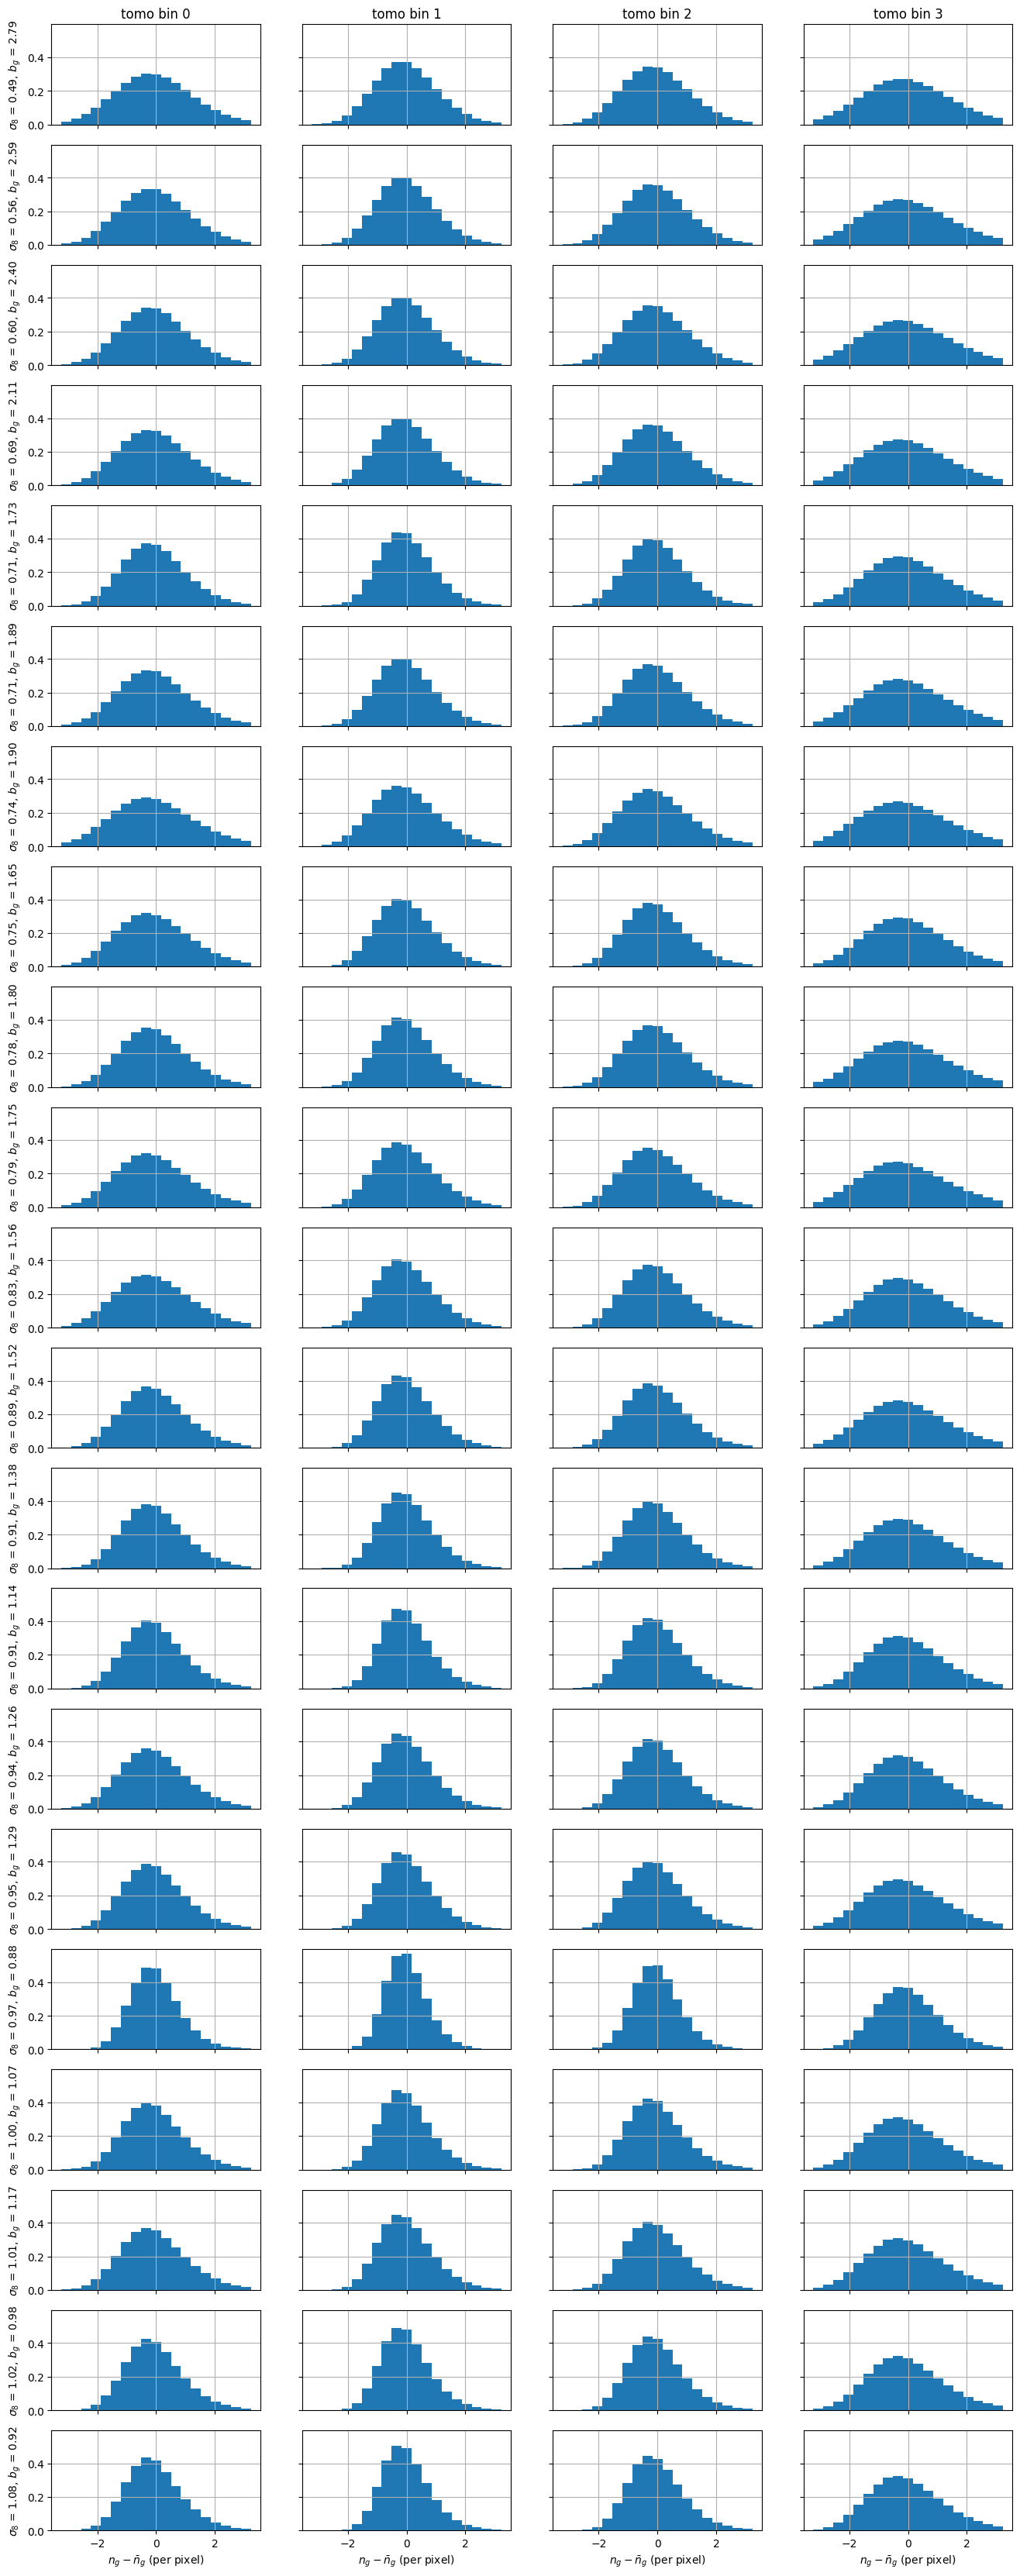

In [33]:
# min_gals = np.quantile(data_vectors, 0.01)
# max_gals = np.quantile(data_vectors, 0.99)
max_gals = np.quantile(np.abs(data_vectors), 0.99)
min_gals = - max_gals

bins = np.linspace(min_gals, max_gals, 20)

fig, ax = plt.subplots(nrows=n_cosmos, ncols=n_tomo, sharex=True, sharey=True, figsize=(4*n_tomo, 2*n_cosmos))

for i in tqdm(range(n_cosmos)):
    for j in range(n_tomo):
        current_pix = data_vectors[i,:,:,j].ravel()
        
        # remove the padding
        current_pix = current_pix[current_pix != 0]
        
        ax[i,j].hist(current_pix, bins=bins, density=True)
        
        # cosmetics
        ax[i,j].grid(True)
        
        if j==0:
            ax[i,j].set(ylabel=r"$\sigma_8$ = " + f"{cosmos[i,1]:.2f}, " + r"$b_g$ = " + f"{cosmos[i,8]:.2f}")
            # ax[i,j].set(ylabel=r"$\sigma_8$ = " + f"{cosmos[i,1]:.2f}, " + r"$b_g$ = " + f"{cosmos[i,8]:.2f}\n" r"$\Omega_m$ = " + f"{cosmos[i,0]:.2f}, " + r"$w_0$ = " + f"{cosmos[i,5]:.2f}, " + r"$\eta_{b_g}$ = " + f"{cosmos[i,9]:.2f}")

        if i == 0:
            ax[i,j].set(title=f"tomo bin {j}")
            
        if i == n_cosmos - 1:
            ax[i,j].set(xlabel=r"$n_g - \bar{n}_g$ (per pixel)")

# fig.suptitle("pixel value (galaxy number) histograms", size=20, y=0.9999)
fig.savefig(f"plots/pixel_histogram_{file_label}.png", bbox_inches="tight", dpi=100)

In [28]:
i_example = 0
square_pix = 500
reso = 1

gnoms = np.zeros((n_cosmos, n_tomo, 500, 500))

for i in range(n_cosmos):
    for j in range(n_tomo):
        dv_map = data_vectors[i,i_example,:,j]
        # same mask as in the forward model
        # dv_map = np.ma.masked_where(grid_pipe.masks_maglim[:,0]==0, dv_map)

        hp_map = np.zeros(n_pix)
        hp_map[data_vec_pix] = dv_map
        
        gnoms[i,j] = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=square_pix, ysize=square_pix, return_projected_map=True, no_plot=True)

gnoms = np.ma.masked_where(gnoms==0, gnoms)

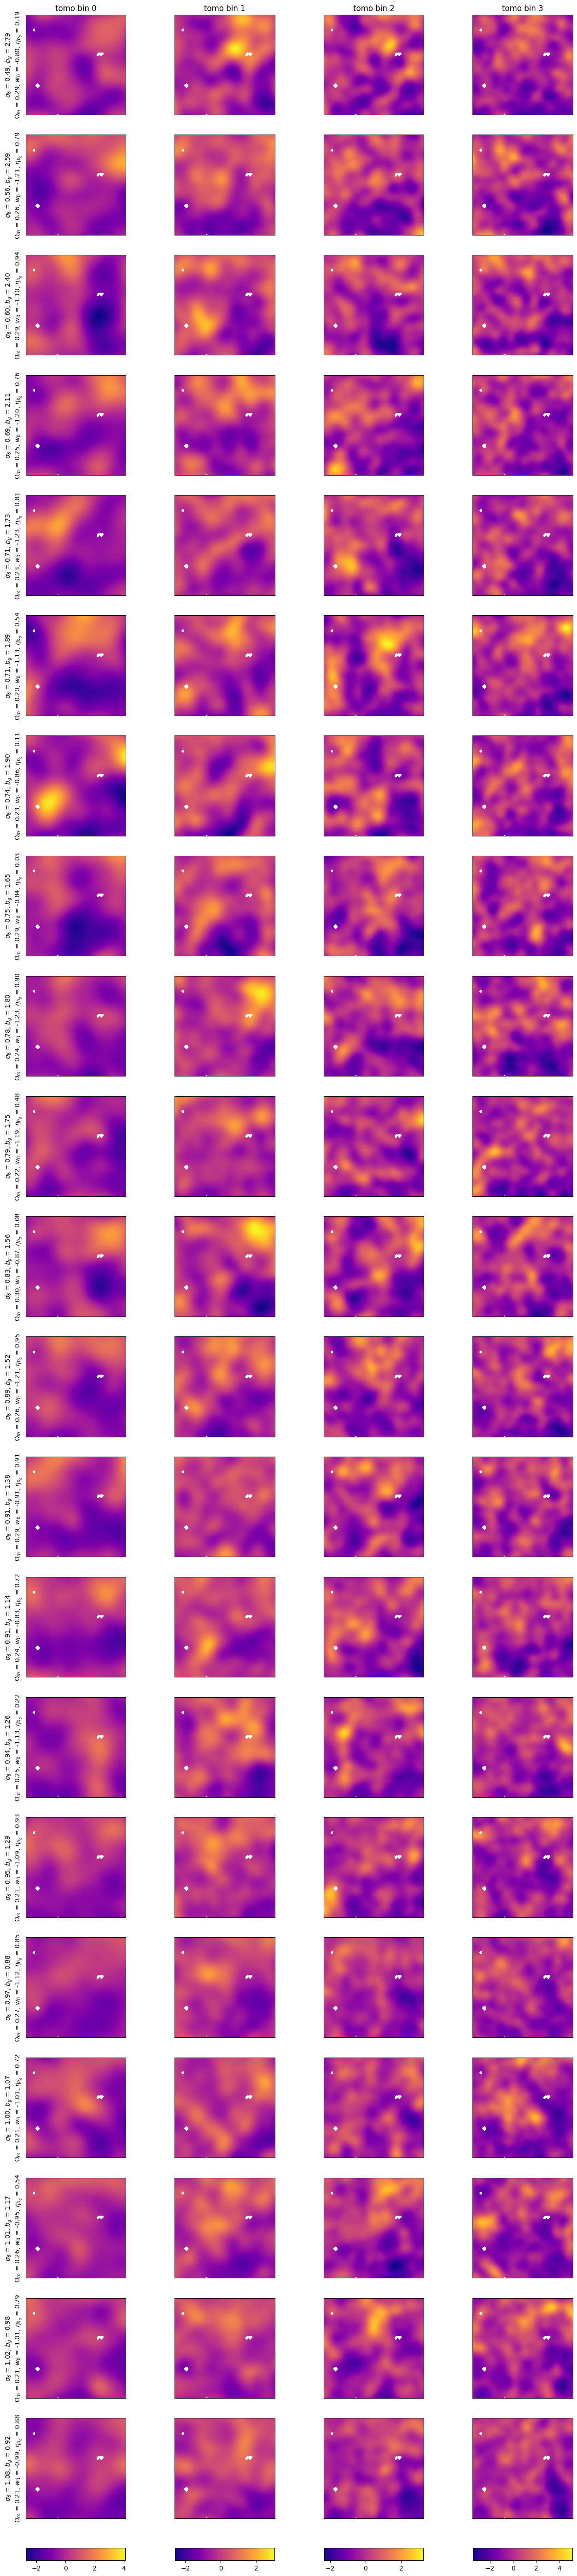

In [29]:
vmin = gnoms.min(axis=(0,2,3))
vmax = gnoms.max(axis=(0,2,3))

# highlight values that are equal to zero
cmap = matplotlib.cm.get_cmap('plasma')
cmap.set_under('red')

fig, ax = plt.subplots(nrows=n_cosmos, ncols=n_tomo, figsize=(n_tomo*4, n_cosmos*4), sharex=True, sharey=True)

for i in range(n_cosmos):
    for j in range(n_tomo):
        im = ax[i,j].imshow(gnoms[i,j], vmin=vmin[j], vmax=vmax[j], cmap=cmap)
        
        # cosmetics
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        
        if i==0:
            ax[i,j].set(title=f"tomo bin {j}")
        
        if i==n_cosmos-1:
            fig.colorbar(im, ax=ax[:,j], orientation="horizontal", shrink=0.8, aspect=8, pad=0.01, location="bottom")
            
        if j==0:
            ax[i,j].set(ylabel=r"$\sigma_8$ = " + f"{cosmos[i,1]:.2f}, " + r"$b_g$ = " + f"{cosmos[i,8]:.2f}\n" r"$\Omega_m$ = " + f"{cosmos[i,0]:.2f}, " + r"$w_0$ = " + f"{cosmos[i,5]:.2f}, " + r"$\eta_{b_g}$ = " + f"{cosmos[i,9]:.2f}")

fig.savefig(f"plots/maps_{file_label}.png", bbox_inches="tight", dpi=100)